In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import itertools
import ast

In [13]:
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses

import torch 
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from transformers import AutoModel, BertTokenizerFast, RobertaTokenizer


In [4]:
df_clean = pd.read_pickle("df_clean_v3_13122021_py35.pkl")

#### Create the training dataset

In [5]:
def get_lyrs_data(genre,attributes):
    all_lyrs=[]
    all_attrs=torch.tensor([])
    genre_labels = []
    for i,g in enumerate(genre):
        lyrsd = df_clean[df_clean["genre"] == g]
        lyrs = list(lyrsd["lyrics"][:].values)
        genre_labels += [i]*len(lyrs)
        all_lyrs += lyrs
        
        attrs = []
        for a in attributes:
            attrs.append(lyrsd[a].to_list())
        attrs = torch.cat([torch.tensor(t).reshape(-1,1) for t in attrs],1)
        all_attrs = torch.cat([all_attrs,attrs],0)
    return all_lyrs,all_attrs,genre_labels

In [6]:
def get_splitlyrs_data(genre,attributes):
    all_first_lyrs=[]
    all_sec_lyrs=[]
    all_attrs=torch.tensor([])
    genre_labels = []
    for i,g in enumerate(genre):
        lyrsd = df_clean[df_clean["genre"] == g]
        lyrs = list(lyrsd["lyrics"][:].values)
        genre_labels += [i]*len(lyrs)
        for lyr in lyrs:
            lyrlen = len(lyr)//2
            first_half = lyr[:lyrlen]
            sec_half = lyr[lyrlen:]
            
            all_first_lyrs += [first_half]
            all_sec_lyrs += [sec_half]
        
        attrs = []
        for a in attributes:
            attrs.append(lyrsd[a].to_list())
        attrs = torch.cat([torch.tensor(t).reshape(-1,1) for t in attrs],1)
        all_attrs = torch.cat([all_attrs,attrs],0)
    return all_first_lyrs,all_sec_lyrs,all_attrs,genre_labels

In [7]:
genres = df_clean["genre"].unique()
# attr = ['danceability','energy','valence']
attr = ['valence']
Xf,Xs,y,g_l = get_splitlyrs_data(genres,attr)
print(len(Xf),len(Xs),y.shape)

15916 15916 torch.Size([15916, 1])


In [7]:
Xf[0]

"Thought I'd end up with Sean. But he wasn't a match. Wrote some songs about Ricky. Now I listen and laugh. Even almost got married. And for Pete, I'm so thankful. Wish I could say, Thank you to Malcolm. 'Cause he was an angel. One taught me love. One taught me patience. And one taught me pain. Now, I'm so amazing. Say I've loved and I've lost. But that's not what I see. So, look what I got. Look what you taught me. And for that, I say. Thank you, next (Next). Thank you, next (Next). Thank you, next. I'm so fuckin' grateful for my ex. Thank you, next (Next). Thank you, next (Next). Thank you, next (Next). I'm so fuckin'—. Spend more time with my friends. I ain't worried 'bout nothin'. Plus, I met someone else. We havin' better discussions. I know they say I move on too fast. But this one gon' last. 'Cause her name is Ari. And I'm so good with that (So good with that). She taught me love (Love). She taught me patience (Patience). How she handles pain (Pain). That shit's amazing (Yeah, s

In [8]:
Xs[0]

"t (Thank you, next). Thank you, next (Thank you). I'm so fuckin' grateful for my ex. Thank you, next (Thank you, next). Thank you, next (Said thank you, next). Thank you, next (Next). I'm so fuckin' grateful for my ex. Thank you, next. Thank you, next. Thank you, next. I'm so fuckin'—. One day I'll walk down the aisle. Holding hands with my mama. I'll be thanking my dad. 'Cause she grew from the drama. Only wanna do it once, real bad. Gon' make that shit last. God forbid something happens. Least this song is a smash (Song is a smash). I've got so much love (Love). Got so much patience (Patience). I've learned from the pain (Pain). I turned out amazing (Turned out amazing). Say I've loved and I've lost (Yeah, yeah). But that's not what I see (Yeah, yeah). 'Cause look what I've found (Yeah, yeah). Ain't no need for searching. And for that, I say. Thank you, next (Thank you, next). Thank you, next (Thank you, next). Thank you, next. I'm so fuckin' grateful for my ex. Thank you, next (Tha

### Define Arch

In [9]:
class BertModelBase(nn.Module):
    def __init__(self,base_model):
        super(BertModelBase,self).__init__()
        
        self.base_model = base_model
#         self.freeze_params(self.base_model)
        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,512)
        
      
    def freeze_params(self,net):
        for p in net.parameters():
            p.require_grads = False
    
    def D(self,p, z, version='simplified'):

        return - F.cosine_similarity(p, z.detach(), dim=-1).mean()

    def forward(self,sent_id1,mask1,sent_id2,mask2):
        baseout1 = self.base_model(sent_id1, attention_mask=mask1)['pooler_output']
        baseout2 = self.base_model(sent_id2, attention_mask=mask2)['pooler_output']

        z1 = self.fc1(baseout1)
        z1 = self.relu(z1)

        z2 = self.fc1(baseout2)
        z2 = self.relu(z2)
        

        # output layer
        p1 = self.fc2(z1)
        p1 = self.relu(p1)
        
        p2 = self.fc2(z2)
        p2 = self.relu(p2)
        
        L = self.D(p1, z2) / 2 + self.D(p2, z1) / 2

        return L

In [14]:
# bert = AutoModel.from_pretrained('bert-base-uncased')
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# model = BertModelBase(bert)
# model = BertModelAttributes(mpnet_base,1)
# tokenizer = model.tokenizer

bert = AutoModel.from_pretrained('sentence-transformers/all-distilroberta-v1')
tokenizer = RobertaTokenizer.from_pretrained('sentence-transformers/all-distilroberta-v1')
model = BertModelBase(bert)


In [15]:
tokens_train_firsthalf = tokenizer.batch_encode_plus(
    Xf,
    max_length = 512,
    padding=True,
    truncation=True
)
tokens_train_sechalf = tokenizer.batch_encode_plus(
    Xs,
    max_length = 512,
    padding=True,
    truncation=True
)


In [16]:
train_seq_first = torch.tensor(tokens_train_firsthalf['input_ids'])
train_mask_first = torch.tensor(tokens_train_firsthalf['attention_mask'])

train_seq_sec = torch.tensor(tokens_train_sechalf['input_ids'])
train_mask_sec = torch.tensor(tokens_train_sechalf['attention_mask'])

train_y = y
# train_y = torch.tensor(g_l)

#### Dataloader and optimizer

In [17]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq_first, train_mask_first, train_seq_sec,train_mask_sec)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

notrain_dataloader = DataLoader(train_data, batch_size=batch_size)

In [18]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-3)          # learning rate

celoss = nn.CrossEntropyLoss()

#### Single Train epoch

In [19]:
def train():
    model.cuda()
    model.train()
    total_loss, total_accuracy = 0, 0
  
    all_loss = []
  
    # iterate over batches
    for step,batch in enumerate(tqdm(train_dataloader)):

        # push the batch to gpu
        batch = [r.to('cuda') for r in batch]

        sent_id1, mask1, sent_id2, mask2 = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        loss = model(sent_id1, mask1,sent_id2, mask2 )
#         print(preds, labels)


        all_loss.append(loss.item())


        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

    return all_loss

In [20]:
lossoverepoch = []
for i in range(2):
    lossoverepoch += train()

100%|██████████| 995/995 [08:01<00:00,  2.06it/s]


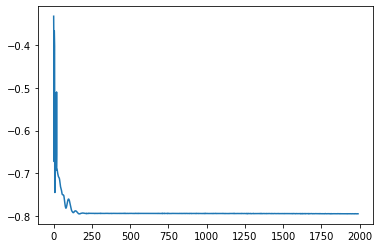

In [22]:
import matplotlib.pyplot as plt
ll=[]
for l in lossoverepoch:
    if l<1:
        ll.append(l)
plt.plot(ll)